In [ ]:
import os, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from _utils import MMDataset

class HDUMEC(nn.Module):
    def __init__(self, embed_dim=200, num_samples=10000, num_views=3, feature_dims=[1000, 1000, 500], hidden_dims=[512, 512, 512], n_clusters=10, alpha=1.0):
        super(HDUMEC, self).__init__()
        self.embed_dim = embed_dim; self.num_samples = num_samples; self.num_views = num_views; self.feature_dims = feature_dims; self.hidden_dims = hidden_dims; self.n_clusters = n_clusters; self.alpha = alpha
        # 1. Multi-view Feature Extraction by Fusion-Net
        self.fusion_net_encoder = nn.ModuleList([nn.Sequential(nn.Linear(feature_dims[i], hidden_dims[i]), nn.BatchNorm1d(hidden_dims[i]), nn.ReLU(),
                                                               nn.Linear(hidden_dims[i], embed_dim)) for i in range(num_views)]) # encode each view
        self.fusion_net_mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=10, batch_first=True) # batch_first=True: (batch_size, seq_len, hidden_dim)
        self.fusion_net_linear = nn.Linear(3*embed_dim, embed_dim) # linear projection of the fused encoded features
        # 2. Uncertainty-Aware Reconstruction by Reconstruction-Net and Uncertainty-Net
        self.reconstruct_net_list = nn.ModuleList([nn.Sequential(nn.Linear(self.embed_dim, hidden_dims[i]), nn.BatchNorm1d(hidden_dims[i]), nn.ReLU(), 
                                                                 nn.Linear(hidden_dims[i], feature_dims[i])) for i in range(num_views)]) # reconstruct each view
        self.uncertainty_net_list = nn.ModuleList([nn.Sequential(nn.Linear(self.embed_dim, hidden_dims[i]), nn.BatchNorm1d(hidden_dims[i]), nn.ReLU(), 
                                                                 nn.Linear(hidden_dims[i], feature_dims[i])) for i in range(num_views)]) # predict uncertainty for each view
        # 3. Deep Embedding Clustering by DEC
        self._cluster_centers = nn.Parameter(torch.Tensor(self.n_clusters, self.embed_dim))
        nn.init.xavier_uniform_(self._cluster_centers.data)
        
    def forward_embedding(self, x):
        encoded_output_list = [self.fusion_net_encoder[i](x[i]) for i in range(self.num_views)] # encode each view
        encoded_output_list = torch.stack(encoded_output_list, dim=1) # stack the encoded features from all views, (batch_size, num_views, embed_dim)
        encoded_output_list, _ = self.fusion_net_mha(encoded_output_list, encoded_output_list, encoded_output_list) # fuse the encoded features from all views by a multihead attention, (batch_size, num_views, embed_dim)
        encoded_output_list = encoded_output_list.contiguous().view(encoded_output_list.shape[0], -1) # flatten the encoded features, (batch_size, num_views*embed_dim)
        embedding = self.fusion_net_linear(encoded_output_list) # linear projection of the fused encoded features
        return embedding # get the embedding of the latent space H, (batch_size, embed_dim)

    def forward_uncertainty_aware_reconstruction(self, x):
        embedding = self.forward_embedding(x) # shape: [batch_size, embed_dim]
        reconstructions = [self.reconstruct_net_list[i](embedding) for i in range(self.num_views)] # reconstruct each view
        uncertainties = [self.uncertainty_net_list[i](embedding) for i in range(self.num_views)] # predict uncertainty for each view
        return reconstructions, uncertainties
        
    def forward_similarity_matrix_q(self, x): # calculate the similarity matrix q using t-distribution
        embedding = self.forward_embedding(x) # shape: [batch_size, embed_dim]
        q = 1.0 / (1.0 + torch.sum((embedding.unsqueeze(1) - self._cluster_centers) ** 2, dim=2) / self.alpha) # shape: [batch_size, n_clusters]
        q = q ** ((self.alpha + 1.0) / 2.0) # , shape: [batch_size, n_clusters]
        q = q / torch.sum(q, dim=1, keepdim=True) # Normalize q to sum to 1 across clusters, shape: [batch_size, n_clusters]
        return q, embedding # q can be regarded as the probability of the sample belonging to each cluster
    
    @property
    def cluster_centers(self):
        return self._cluster_centers.data.detach().cpu().numpy() # shape: (n_clusters, embed_dim)
    
    @cluster_centers.setter
    def cluster_centers(self, centers): # shape: (n_clusters, embed_dim)
        centers = torch.tensor(centers, dtype=torch.float32, device=self._cluster_centers.device)
        self._cluster_centers.data.copy_(centers) # copy the cluster centers to the model, set the cluster centers to the new cluster centers
        
    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / torch.sum(q, dim=0) # shape: [batch_size, n_clusters]
        p = weight / torch.sum(weight, dim=1, keepdim=True) # Normalize p to sum to 1 across clusters, shape: [batch_size, n_clusters]
        return p.clone().detach()
    
    def reconstruction_loss(self, x):
        x_rec, _ = self.forward_uncertainty_aware_reconstruction(x) # reconstruct each view and predict uncertainty
        return sum([F.mse_loss(x_rec[v], x[v], reduction='mean') for v in range(self.num_views)]) # sum the losses from all views
    
    def uncertainty_aware_reconstruction_loss(self, x):
        x_rec, log_sigma_2 = self.forward_uncertainty_aware_reconstruction(x) # reconstruct each view and predict uncertainty
        return sum([0.5 * torch.mean((x_rec[v] - x[v])**2 * torch.exp(-log_sigma_2[v]) + log_sigma_2[v]) for v in range(self.num_views)]) # uncertainty is equal to log_sigma_2
    
    def clustering_loss(self, x, p):
        q, _ = self.forward_similarity_matrix_q(x) # shape: [batch_size, n_clusters]
        return F.kl_div(q.log(), p, reduction='batchmean') # shape: ()

In [ ]:
def predict_uncertainty_with_HDUMEC(data, data_views, data_samples, data_features, data_categories):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HDUMEC(embed_dim=20, feature_dims=data_features, num_views=data_views, hidden_dims=[512, 512, 512], num_samples=data_samples, n_clusters=data_categories, alpha=1.0).to(device)
    # print("\n=== Stage 1: Uncertainty-Aware Reconstruction Pretraining ===")
    # print("Basic reconstruction training...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        loss = model.reconstruction_loss(data)
        loss.backward()
        optimizer.step()
        # print(f'Epoch {epoch} completed. Average Loss: {loss.item():.4f}')
    # print("Uncertainty-aware reconstruction finetuning...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        loss = model.uncertainty_aware_reconstruction_loss(data)
        loss.backward()
        optimizer.step()
        # print(f'Epoch {epoch} completed. Average Loss: {loss.item():.4f}')
    model.eval()
    with torch.no_grad():
        reconstructions, uncertainties = model.forward_uncertainty_aware_reconstruction(data)
        embeddings = model.forward_embedding(data).cpu().numpy()
    uncertainties = [np.exp(0.5 * uncertainties[i].cpu().numpy()) for i in range(data_views)]
    modality_uncertainties = [np.mean(uncertainties[i], axis=1) for i in range(data_views)]
    sample_uncertainties = np.vstack(modality_uncertainties) # shape: (batch_size, num_views)
    sample_uncertainties = np.sum(sample_uncertainties, axis=0) # shape: (batch_size,)
    return sample_uncertainties, embeddings

In [ ]:
random.seed(0); np.random.seed(0); torch.manual_seed(0); torch.cuda.manual_seed_all(0) # Set random seed for reproducibility, change the seed to get different but maybe better results.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = MMDataset('./data/data_sc_multiomics/TEA/', concat_data=False)
data = [x.clone().to(device) for x in dataset.X]; label = dataset.Y.clone().numpy()
data_views = dataset.data_views; data_samples = dataset.data_samples; data_features = dataset.data_features; data_categories = dataset.categories
label_dict_TEA = dataset.get_label_to_name()
label_TEA = label
sample_uncertainties_TEA, embeddings_TEA = predict_uncertainty_with_HDUMEC(data, data_views, data_samples, data_features, data_categories)

modality_rna shape: (25517, 50)
modality_protein shape: (25517, 47)
modality_atac shape: (25517, 30)


<Figure size 2400x1600 with 0 Axes>

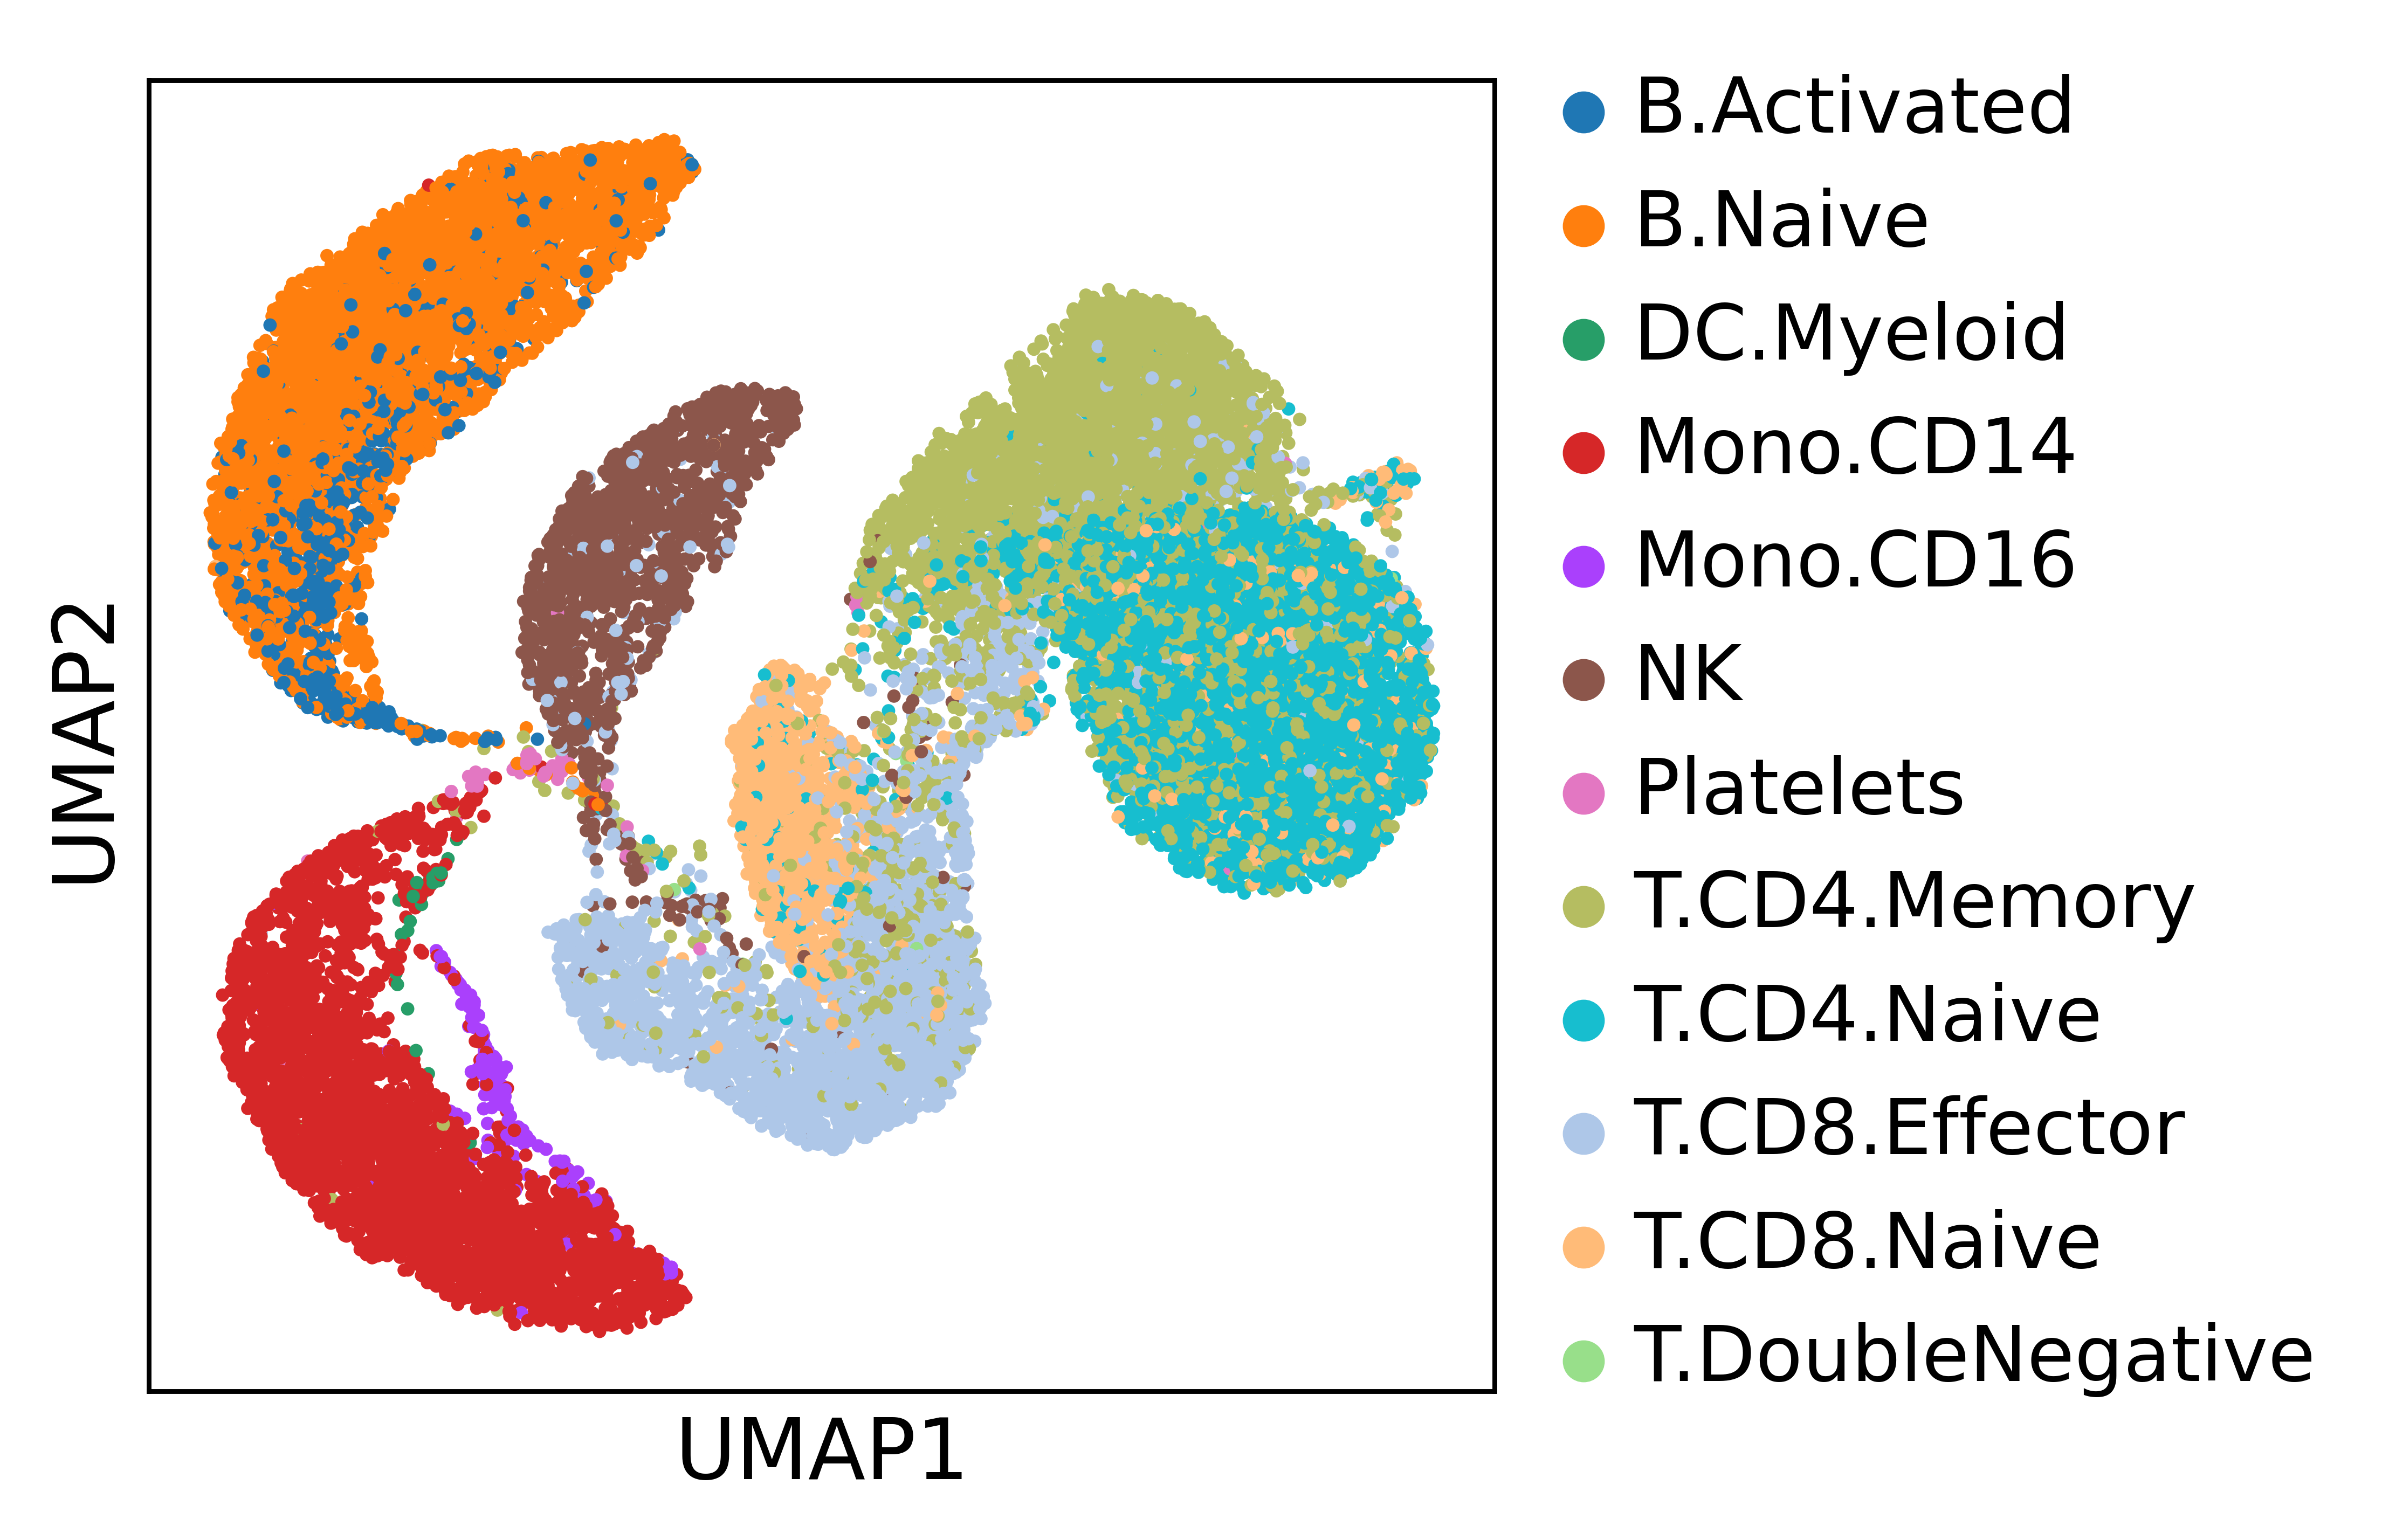

<Figure size 1600x1600 with 0 Axes>

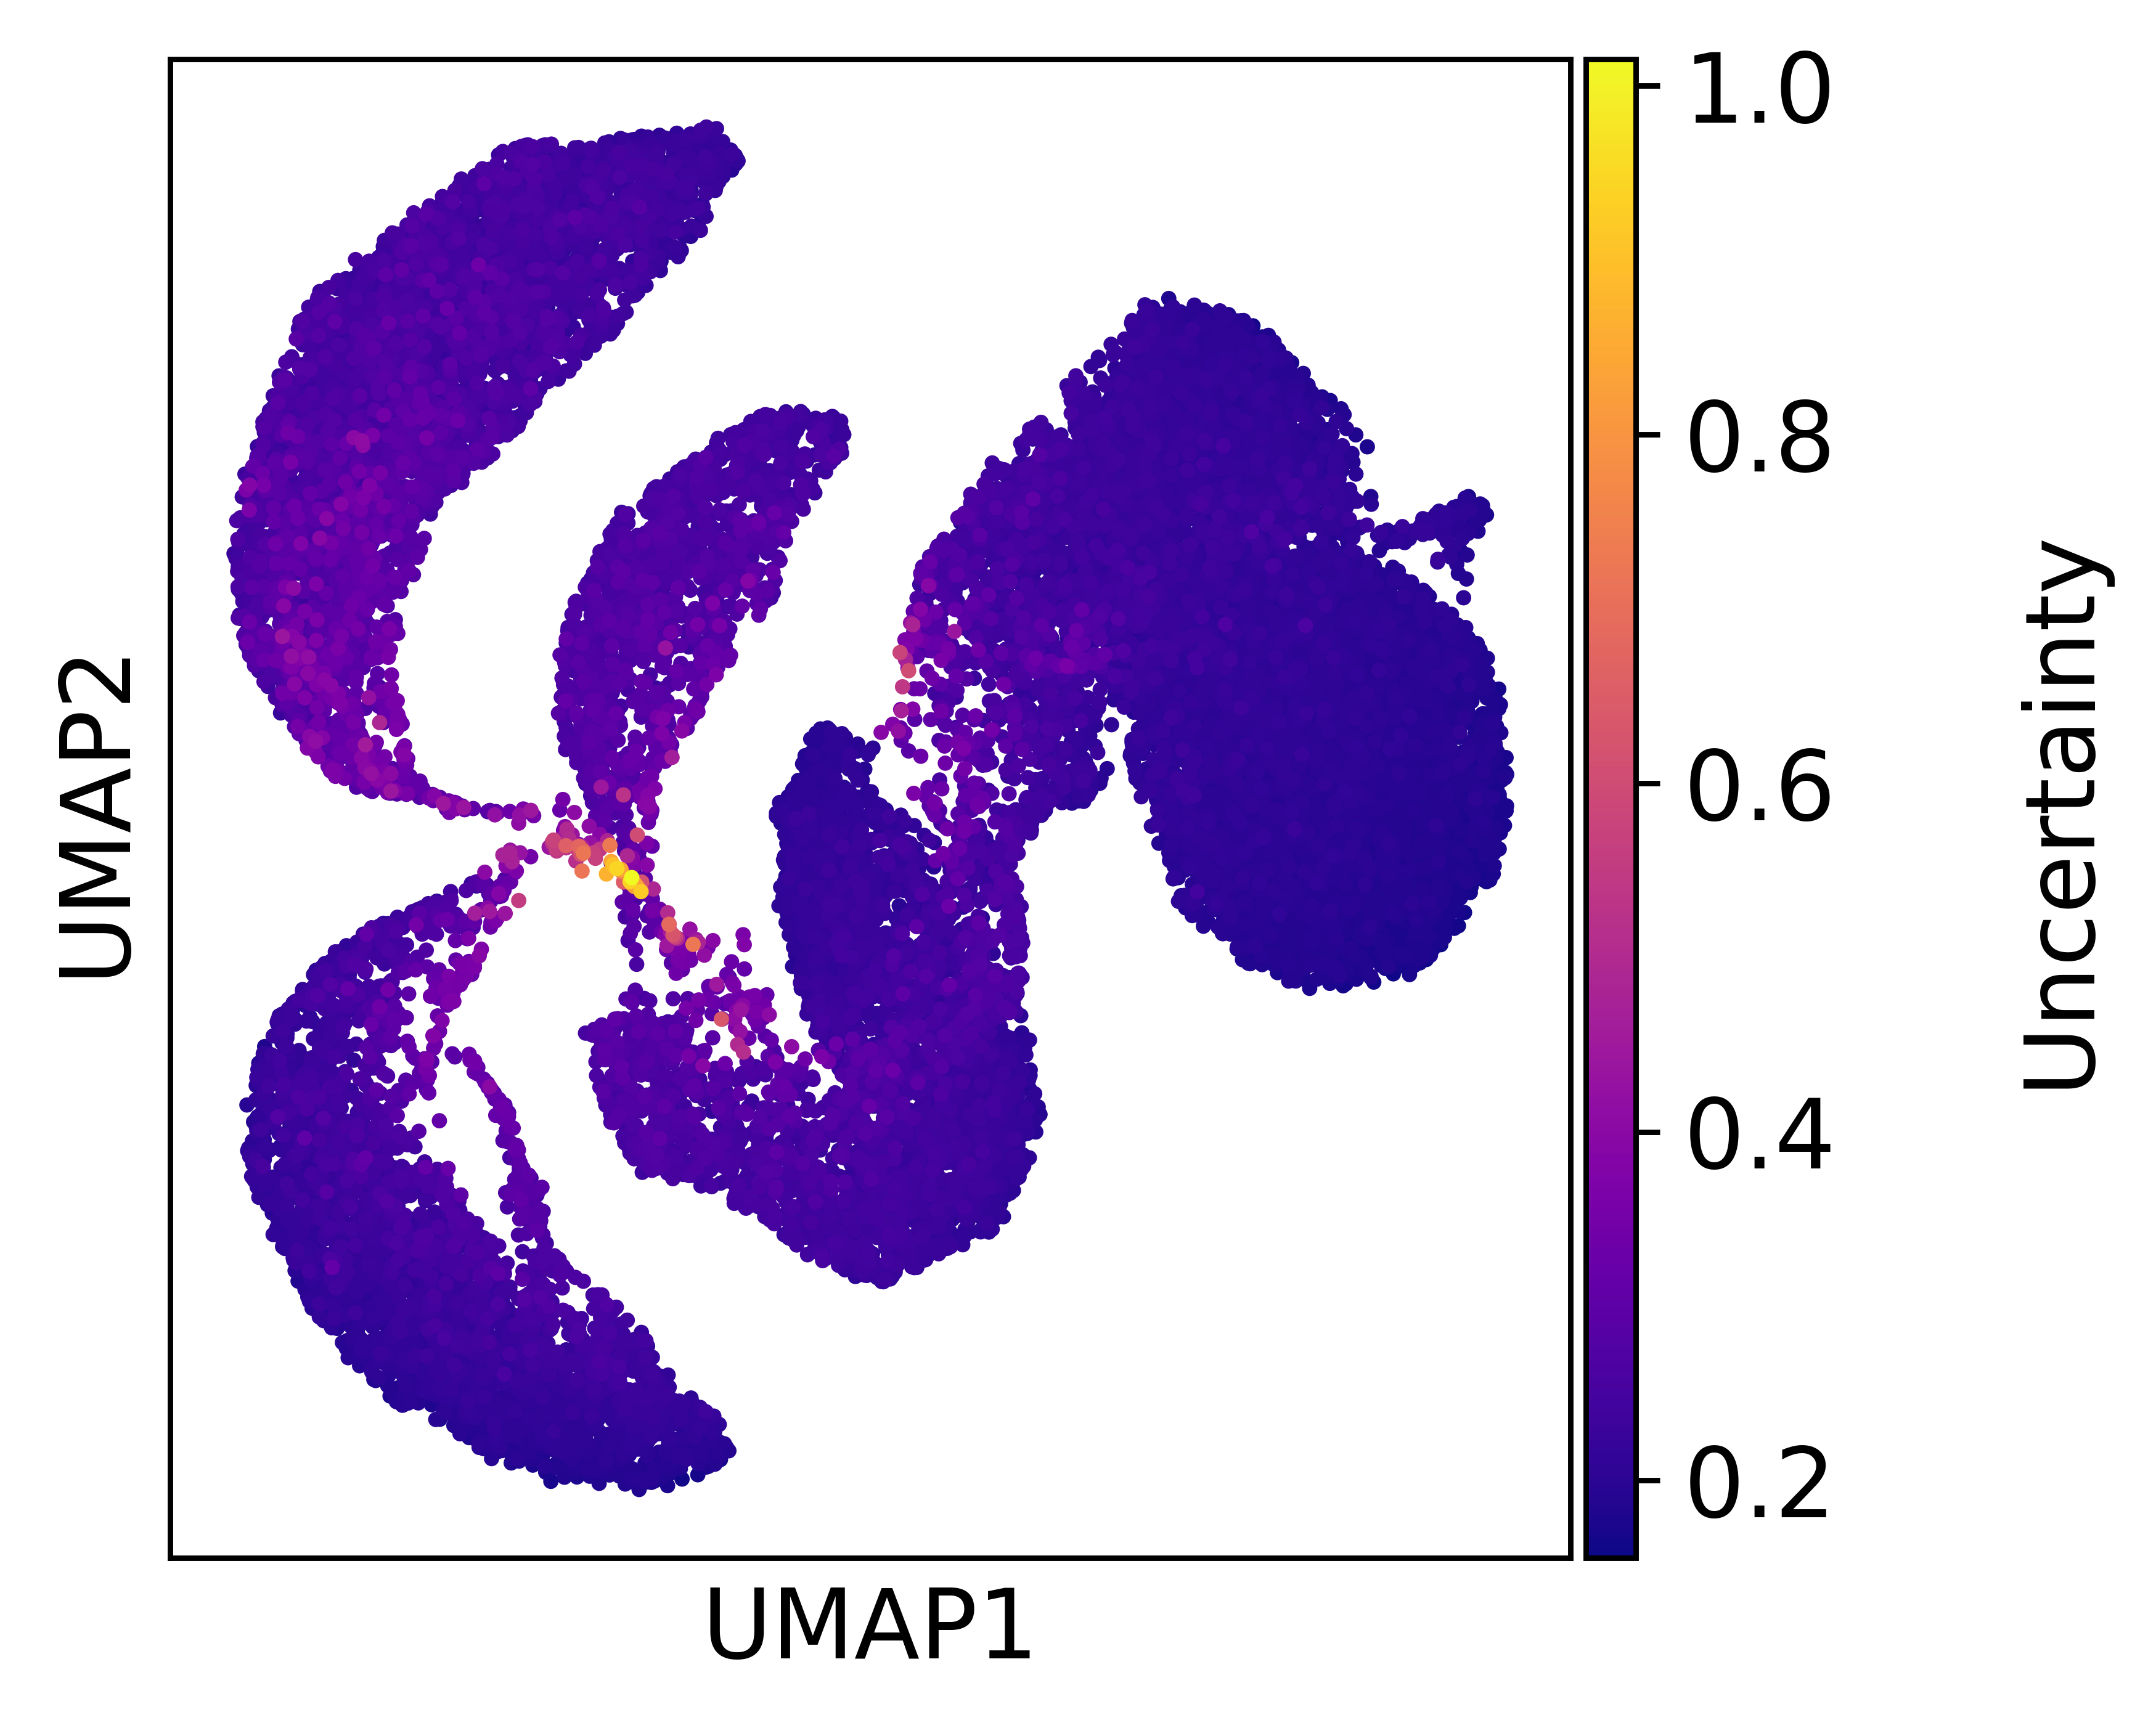

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import scanpy as sc
import pandas as pd
import anndata as ad

def plot_umap_by_label_scanpy(embeddings, sample_uncertainties, label, label_dict, save_dir=None):
    os.makedirs(save_dir, exist_ok=True)
    sc.settings.set_figure_params(dpi=400, facecolor='white', fontsize=14, frameon=False)
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['font.size'] = 14
    adata = ad.AnnData(embeddings, obs=pd.DataFrame(index=[f'cell_{i}' for i in range(embeddings.shape[0])]), var=pd.DataFrame(index=[f'embedding_{i}' for i in range(embeddings.shape[1])]))
    adata.obs['cell_type'] = [label_dict.get(int(l)) for l in label]
    adata.obs['uncertainty'] = sample_uncertainties
    sc.pp.neighbors(adata, use_rep='X')
    sc.tl.umap(adata, n_components=2)
    plt.figure(figsize=(6, 4))
    sc.pl.umap(adata, color='cell_type', size=20, show=False, frameon=True, title='')
    plt.title('', fontsize=14, fontweight='bold')
    plt.savefig(os.path.join(save_dir, 'stage_1_sample_uncertainty_umap_by_label.png'), dpi=400, bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(4, 4))
    sc.pl.umap(adata, color='uncertainty', cmap='plasma', size=20, show=False, frameon=True, title='')
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[1] + (xlim[1] - xlim[0]) * 0.35, (ylim[0] + ylim[1]) / 2, 'Uncertainty', 
            rotation=90, ha='center', va='center', fontsize=14)
    
    plt.title('', fontsize=14, fontweight='bold')
    plt.savefig(os.path.join(save_dir, 'stage_1_sample_uncertainty_umap_by_uncertainty.png'), dpi=400, bbox_inches='tight')
    plt.show()

plot_umap_by_label_scanpy(embeddings_TEA, sample_uncertainties_TEA, label_TEA, label_dict_TEA, './figures/')